In [ ]:
#Kernel Non-negative Tensor Factorization

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.io as sio #to load mat files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<h2>1. Loading dataset CMU Faces</h2>

$\mathcal{TF}\in\mathbb{R}_+^{30\times11\times21\times1024}$

In [2]:
sio.whosmat('../datasets/CMU(30x11x21x1024).mat')

[('FullTensor', (30, 11, 21, 1024), 'uint8')]

In [3]:
matTF = sio.loadmat('../datasets/CMU(30x11x21x1024).mat')#loading tensor of formatted faces' images

In [4]:
TF = matTF['FullTensor']

In [5]:
TF.shape

(30, 11, 21, 1024)

1.1 Tensor matrization

$MF\in\mathbb{R}_+^{6930\times1024}$

In [6]:
MF = np.reshape(TF,(30*11*21,1024))

Some images which compound the tensor:

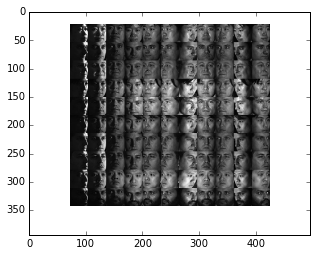

In [7]:
img=mpimg.imread('../datasets/faces_sample.png')
imgplot = plt.imshow(img)

<h3> 1.1 Preprocessing to incomplete data</h3>

In [85]:
rt_obinc = 0.92 # rate of objects incomplete
rt_incpob = 0.5 # rate of minimun elements (attributes or variables) incomplete for each object
idx_inc = np.sort(np.random.choice(MF.shape[0], MF.shape[0]*rt_obinc, replace=False))
idx_v = np.ones(MF.shape[0])
idx_v[idx_inc] = 0
idx_s = np.vstack((idx_v,idx_v)).repeat([1,MF.shape[1]-1],0).T
idx_com = np.arange(0,MF.shape[0]-1)
idx_com = np.delete(idx_com, idx_inc)
data_i = MF[idx_inc]#subset with incomplete elements
data_c = MF[idx_com]#subset with complete elements

In [86]:
idx_s2 = np.copy(idx_s) # idx_s2 could have partially incomplete objects
for i in idx_inc:
    idx_s2[i] = np.random.permutation(np.append(np.random.randint(2,size=MF.shape[1]*(1-rt_incpob)),np.zeros(MF.shape[1]*rt_incpob)))

#plt.pcolor(idx_s2)
#plt.colorbar()

In [87]:
MF_ci = MF * idx_s2
#plt.pcolor(MF_ci)
#plt.colorbar()

<h3>1.1.1 Selecting a sample</h3>

In [11]:
MFs_ci = MF_ci[:MF_ci.shape[0]/6]
print MFs_ci.shape

(1155, 1024)


<h2>2. Convex-NMF</h2>

In [7]:
import kernel as kernel
import pymf
from pymf.cnmf import CNMF 
import time

In [13]:
#Exploring bases
bases = np.arange(2,MF_ci.shape[1]/16)
fopx = np.ones(len(bases))
for idx,item in enumerate(bases):        
    cnmf = CNMF(MF_ci, item)
    cnmf.factorize(niter=10)
    fopx[idx] = np.linalg.norm(MF - np.dot(cnmf.W,cnmf.H))

min base  13


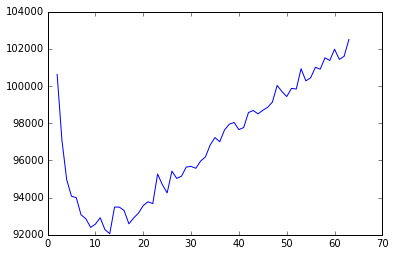

In [14]:
print "min base ", bases[np.argmin(fopx)]
plt.plot(bases,fopx)

In [15]:
cnmf = CNMF(MF_ci, num_bases=13)
cnmf.factorize(niter=10)

In [22]:
print 'Error: ', np.linalg.norm(MF - np.dot(cnmf.W,cnmf.H))/np.linalg.norm(MF)

Error:  12764.3722698


<h2>2.1 Kernelization</h2>

<h3>2.1.1 Convex-NMF with Linear kernel</h3>

Exploration of size of latent space is performed over a sample

In [16]:
KlX_ci = kernel._get_kernel(MFs_ci, MFs_ci,'linear')

In [17]:
bases = np.arange(2,KlX_ci.shape[1]/32)
fopxl_ci = np.ones(len(bases))
for idx,item in enumerate(bases):        
    cnmf_kl_ci = CNMF(KlX_ci, item)
    cnmf_kl_ci.factorize(niter=10)
    fopxl_ci[idx] = np.linalg.norm(KlX_ci - np.dot(cnmf_kl_ci.W,cnmf_kl_ci.H))

min base  8


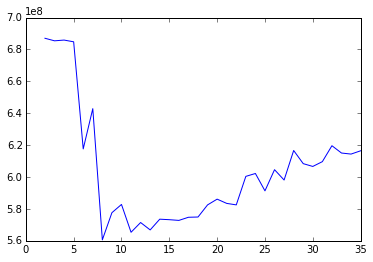

In [18]:
plt.plot(bases,fopxl_ci)
print "min base ", bases[np.argmin(fopxl_ci)]

In [19]:
KlX_ci = kernel._get_kernel(MF_ci, MF_ci,'linear')

In [20]:
cnmf_kl_ci = CNMF(KlX_ci, num_bases=8)
cnmf_kl_ci.factorize(niter=10)
np.linalg.norm(KlX_ci - np.dot(cnmf_kl_ci.W,cnmf_kl_ci.H))

3805244938.8990641

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


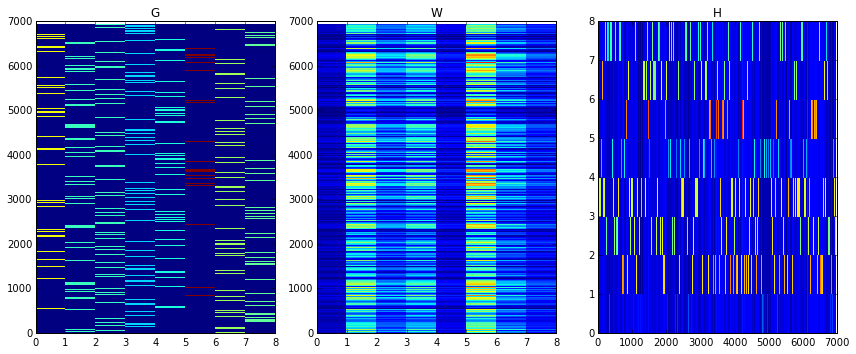

In [23]:
f, axarr = plt.subplots(1, 3)
axarr[0].pcolor(cnmf_kl_ci.G)
axarr[0].set_title('G')
axarr[1].pcolor(cnmf_kl_ci.W)
axarr[1].set_title('W')
axarr[2].pcolor(cnmf_kl_ci.H)
axarr[2].set_title('H')
f.set_size_inches(12,5)
f.tight_layout()

In [25]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 8
preimxkl_ci = np.copy(MF_ci)
tic = time.clock()#get start time
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_kl_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    preimxkl_ci[j], trainErrorskl = kernel.preimage(xs, alpha, 'linear')

toc = time.clock()#get final time
print 'Time: ',toc - tic

Time:  0.672343


In [28]:
print "Error: ",np.linalg.norm(MF_ci - preimxkl_ci)/np.linalg.norm(MF_ci)

Error:  0.288930707443


In [ ]:
#Display completion

<h3>2.1.2. Convex-NMF with Gaussian kernel</h3>

Exploration of size of latent space is performed over a sample

In [29]:
sigma = 78275
KgX_ci = kernel._get_kernel(MFs_ci, MFs_ci,'rbf', gamma=(2*sigma)**-2)

<matplotlib.colorbar.Colorbar instance at 0x7efad43b1fc8>

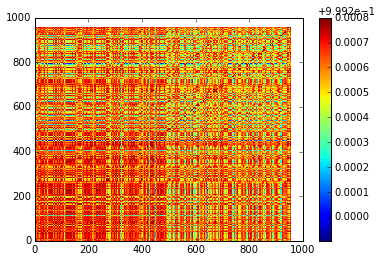

In [109]:
plt.pcolor(KgX_ci[200:,200:])
plt.colorbar()

In [30]:
bases = np.arange(2,KgX_ci.shape[1]/16)
fopxg_ci = np.ones(len(bases))
tic = time.clock()#get start time
for idx,item in enumerate(bases):        
    cnmf_kg_ci = CNMF(KgX_ci, item)
    cnmf_kg_ci.factorize(niter=10)
    fopxg_ci[idx] = np.linalg.norm(KgX_ci - np.dot(cnmf_kg_ci.W,cnmf_kg_ci.H))

toc = time.clock()#get final time
print 'Time: ',toc - tic

Time:  2117.267893


min base  6


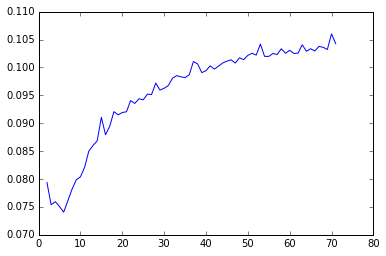

In [31]:
print "min base ", bases[np.argmin(fopxg_ci)]
plt.plot(bases,fopxg_ci)

Exploring sigma:

In [112]:
sigmav1 = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1e1, 1e2, 1e3, 1e4, 1e5 ])

In [118]:
rse_cnmf1 = []
for sigmai in sigmav1:
    KgX_ci = kernel._get_kernel(MF_ci, MF_ci,'rbf', gamma=(2*sigmai)**-2)
    cnmf_kg_ci = CNMF(KgX_ci, num_bases=5)
    cnmf_kg_ci.factorize(niter=10)
    rse_cnmf1.append( np.linalg.norm(KgX_ci - np.dot(cnmf_kg_ci.W,cnmf_kg_ci.H))/np.linalg.norm(KgX_ci) )

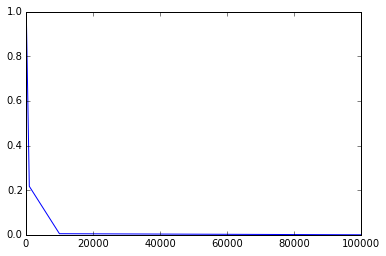

In [119]:
plt.plot(sigmav1, rse_cnmf1)

In [103]:
rse_cnmf2 = []
sigmav2 =  np.linspace(1e4,1.6e5,30)
for sigmai in sigmav:
    KgX_ci = kernel._get_kernel(MF_ci, MF_ci,'rbf', gamma=(2*sigmai)**-2)
    cnmf_kg_ci = CNMF(KgX_ci, num_bases=5)
    cnmf_kg_ci.factorize(niter=10)
    rse_cnmf.append( np.linalg.norm(KgX_ci - np.dot(cnmf_kg_ci.W,cnmf_kg_ci.H))/np.linalg.norm(KgX_ci) )

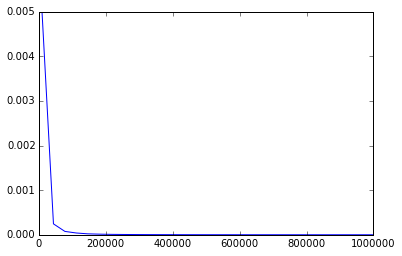

In [110]:
plt.plot(np.linspace(1e4,1e6,30), rse_cnmf)

In [37]:
sigma = 78275
KgX_ci = kernel._get_kernel(MF_ci, MF_ci,'rbf', gamma=(2*sigma)**-2)

In [38]:
#Factorize
cnmf_kg_ci = CNMF(KgX_ci, num_bases=6)
cnmf_kg_ci.factorize(niter=10)
np.linalg.norm(KgX_ci - np.dot(cnmf_kg_ci.W,cnmf_kg_ci.H))

0.53644053119220525

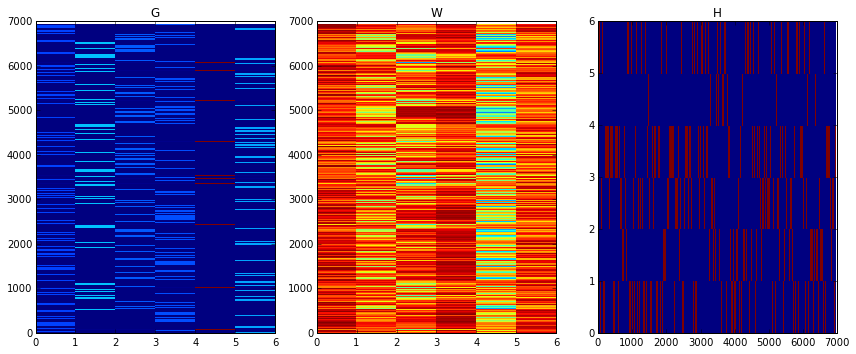

In [39]:
f, axarr = plt.subplots(1, 3)
axarr[0].pcolor(cnmf_kg_ci.G)
axarr[0].set_title('G')
axarr[1].pcolor(cnmf_kg_ci.W)
axarr[1].set_title('W')
axarr[2].pcolor(cnmf_kg_ci.H)
axarr[2].set_title('H')
f.set_size_inches(12,5)
f.tight_layout()

In [40]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 6
preimxkg_ci = np.copy(MF_ci)
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_kg_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    preimxkg_ci[j], trainErrorskg = kernel.preimage_isot(xs, alpha, 'rbf', gamma=(2*sigma)**-2)

In [41]:
print "Error_ori: ",np.linalg.norm(MF - preimxkg_ci)/np.linalg.norm(MF)
print "Error_ci: ",np.linalg.norm(MF_ci - preimxkg_ci)/np.linalg.norm(MF_ci)

Error_ori:  10231.7563944
Error_ci:  0.163765570559


In [ ]:
#Display completion

<h3>2.1.3. Convex-NMF with Linear x Gaussian kernel</h3>

Exploration of size of latent space is performed over a sample

In [70]:
sigma = 1200
KlxgX_ci = kernel._get_kernel(MFs_ci, MFs_ci,'linxrbf', gamma=(2*sigma)**-2)

In [71]:
bases = np.arange(2,KlxgX_ci.shape[1]/32)
fopxlxg_ci = np.ones(len(bases))
for idx,item in enumerate(bases):        
    cnmf_klxg_ci = CNMF(KlxgX_ci, item)
    cnmf_klxg_ci.factorize(niter=10)
    fopxlxg_ci[idx] = np.linalg.norm(KlxgX_ci - np.dot(cnmf_klxg_ci.W,cnmf_klxg_ci.H))

min base  10


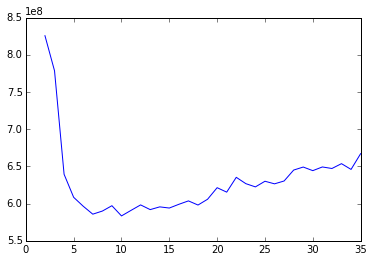

In [72]:
print "min base ", bases[np.argmin(fopxlxg_ci)]
plt.plot(bases,fopxlxg_ci)

Exploring sigma:

In [125]:
sigmav1 = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1e1, 1e2, 1e3, 1e4, 1e5 ])

In [146]:
rse_cnmf1 = []
for sigmai in sigmav1:
    KlxgX_ci = kernel._get_kernel(MF_ci, MF_ci,'linxrbf', gamma=(2*sigmai)**-2)
    cnmf_klxg_ci = CNMF(KlxgX_ci, num_bases=10)
    cnmf_klxg_ci.factorize(niter=10)
    rse_cnmf1.append( np.linalg.norm(KlxgX_ci - np.dot(cnmf_klxg_ci.W,cnmf_klxg_ci.H))/np.linalg.norm(KlxgX_ci) )

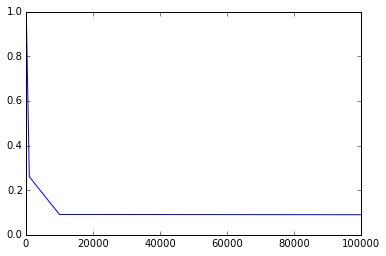

In [152]:
plt.plot(sigmav1, rse_cnmf1)

In [149]:
print rse_cnmf1

[0.99882286580814339, 0.99834274977933646, 0.99888340323306279, 0.99820347474477522, 0.9987046885002967, 0.99710765826624803, 0.99884828963385863, 0.99872184083872417, 0.26043544238036359, 0.091194026067312139, 0.089955816820516232]


In [150]:
rse_cnmf2 = []
sigmav2 =  np.linspace(1e5,1e6,20)
for sigmai in sigmav2:
    KlxgX_ci = kernel._get_kernel(MF_ci, MF_ci,'linxrbf', gamma=(2*sigmai)**-2)
    cnmf_klxg_ci = CNMF(KlxgX_ci, num_bases=10)
    cnmf_klxg_ci.factorize(niter=10)
    rse_cnmf2.append( np.linalg.norm(KlxgX_ci - np.dot(cnmf_klxg_ci.W,cnmf_klxg_ci.H))/np.linalg.norm(KlxgX_ci) )

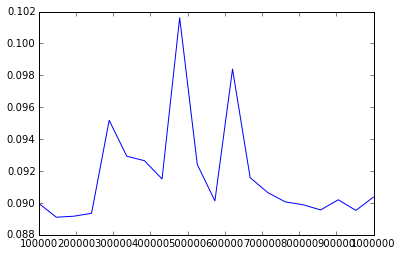

In [151]:
plt.plot(sigmav2, rse_cnmf2)

In [153]:
print "min sigma ", sigmav2[np.argmin(rse_cnmf2)]

min sigma  147368.421053


In [42]:
sigma = 147368.421053
KlxgX_ci = kernel._get_kernel(MF_ci, MF_ci,'linxrbf', gamma=(2*sigma)**-2)

In [43]:
#Factorize
cnmf_klxg_ci = CNMF(KlxgX_ci, num_bases=7)
cnmf_klxg_ci.factorize(niter=10)
np.linalg.norm(KlxgX_ci - np.dot(cnmf_klxg_ci.W,cnmf_klxg_ci.H))

4225488934.5780091

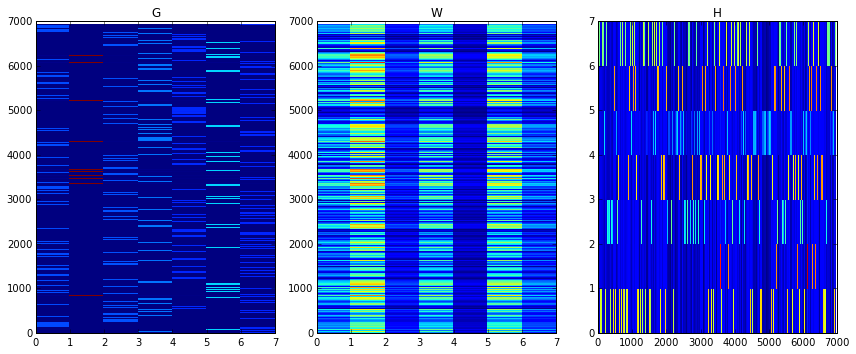

In [44]:
f, axarr = plt.subplots(1, 3)
axarr[0].pcolor(cnmf_klxg_ci.G)
axarr[0].set_title('G')
axarr[1].pcolor(cnmf_klxg_ci.W)
axarr[1].set_title('W')
axarr[2].pcolor(cnmf_klxg_ci.H)
axarr[2].set_title('H')
f.set_size_inches(12,5)
f.tight_layout()

In [45]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 7
preimxklxg_ci = np.copy(MF_ci)
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))
    alpha = cnmf_klxg_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    #print j, xs.shape, alpha.shape
    preimxklxg_ci[j], trainErrorskg = kernel.preimage(xs, alpha, 'linxrbf', gamma=(2*sigma)**-2)

In [47]:
print "Error_ori: ",np.linalg.norm(MF - preimxklxg_ci)/np.linalg.norm(MF)
print "Error_ci: ",np.linalg.norm(MF_ci - preimxklxg_ci)/np.linalg.norm(MF_ci)

Error_ori:  5885.18438573
Error_ci:  0.287240182936


In [48]:
#Display completion

<h3>2.1.4. Convex-NMF with Polynomial x Gaussian kernel</h3>

Exploration of size of latent space is performed over a sample

In [83]:
sigma = 1200
KpxgX_ci = kernel._get_kernel(MFs_ci,MFs_ci,'polyxrbf', gamma=(2*sigma)**-2, degree=2,coef0=1)

<matplotlib.colorbar.Colorbar instance at 0x7fc643fe53f8>

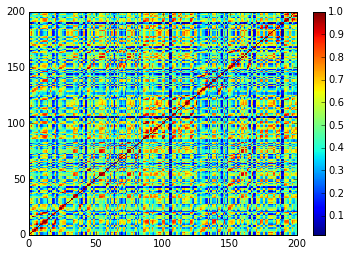

In [90]:
plt.pcolor(KgX_ci[:200,:200])
plt.colorbar()

In [89]:
bases = np.arange(2,KpxgX_ci.shape[1]/16)
fopxpxg_ci = np.ones(len(bases))
for idx,item in enumerate(bases):        
    cnmf_kpxg_ci = CNMF(KpxgX_ci, item)
    cnmf_kpxg_ci.factorize(niter=10)
    fopxpxg_ci[idx] = np.linalg.norm(KpxgX_ci - np.dot(cnmf_kpxg_ci.W,cnmf_kpxg_ci.H))

min base  16


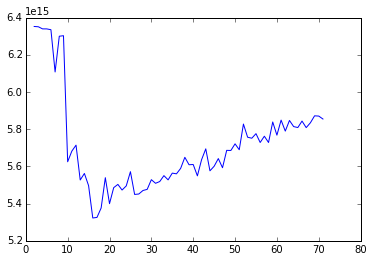

In [91]:
print "min base ", bases[np.argmin(fopxpxg_ci)]
plt.plot(bases,fopxpxg_ci)

In [92]:
#Factorize
cnmf_kpxg_ci = CNMF(KpxgX_ci, num_bases=16)
cnmf_kpxg_ci.factorize(niter=10)
np.linalg.norm(KpxgX_ci - np.dot(cnmf_kpxg_ci.W,cnmf_kpxg_ci.H))

5514023671542391.0

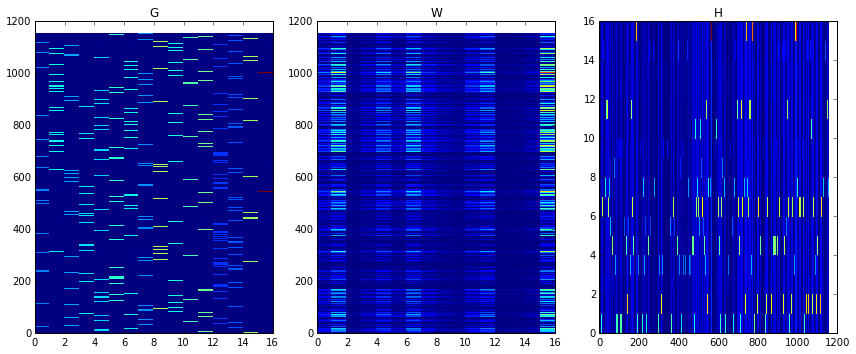

In [93]:
f, axarr = plt.subplots(1, 3)
axarr[0].pcolor(cnmf_kpxg_ci.G)
axarr[0].set_title('G')
axarr[1].pcolor(cnmf_kpxg_ci.W)
axarr[1].set_title('W')
axarr[2].pcolor(cnmf_kpxg_ci.H)
axarr[2].set_title('H')
f.set_size_inches(12,5)
f.tight_layout()

In [103]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 16
preimxkpxg_ci = np.copy(MF_ci)
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_kpxg_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    print j, xs.shape, alpha.shape
    preimxkpxg_ci[j], trainErrorskpxg = kernel.preimage_isot(xs, alpha, 'polyxrbf', gamma=(2*sigma)**-2, degree=2,coef0=1)

0 (16, 1024) (16,)


AttributeError: 'int' object has no attribute 'T'

In [ ]:
print "Error_ori: ",np.linalg.norm(MF - preimxkpxg_ci)
print "Error_ci: ",np.linalg.norm(MF_ci - preimxkpxg_ci)

In [ ]:
#Display completion

<h3>2.1.5 Computing completion error</h3>

In [88]:
#without kernel
cnmf = CNMF(MF_ci, num_bases=10)
cnmf.factorize(niter=10)

In [89]:
#Linear kernel
KlX_ci = kernel._get_kernel(MF_ci, MF_ci,'linear')

cnmf_kl_ci = CNMF(KlX_ci, num_bases=10)
cnmf_kl_ci.factorize(niter=10)
print np.linalg.norm(KlX_ci - np.dot(cnmf_kl_ci.W,cnmf_kl_ci.H))

#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 10
preimxkl_ci = np.copy(MF_ci)
tic = time.clock()#get start time
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_kl_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    preimxkl_ci[j], trainErrorskl = kernel.preimage(xs, alpha, 'linear')

toc = time.clock()#get final time
print 'Time: ',toc - tic

733206499.985
Time:  36.289423


In [90]:
#rbf kernel
sigma = 78275
KgX_ci = kernel._get_kernel(MF_ci, MF_ci,'rbf', gamma=(2*sigma)**-2)

#Factorize
cnmf_kg_ci = CNMF(KgX_ci, num_bases=10)
cnmf_kg_ci.factorize(niter=10)
print np.linalg.norm(KgX_ci - np.dot(cnmf_kg_ci.W,cnmf_kg_ci.H))

#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 10
preimxkg_ci = np.copy(MF_ci)
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_kg_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    preimxkg_ci[j], trainErrorskg = kernel.preimage_isot(xs, alpha, 'rbf', gamma=(2*sigma)**-2)

0.218023839325


In [91]:
#lin x rbf kernel
sigma = 147368.421053
KlxgX_ci = kernel._get_kernel(MF_ci, MF_ci,'linxrbf', gamma=(2*sigma)**-2)

#Factorize
cnmf_klxg_ci = CNMF(KlxgX_ci, num_bases=10)
cnmf_klxg_ci.factorize(niter=10)
np.linalg.norm(KlxgX_ci - np.dot(cnmf_klxg_ci.W,cnmf_klxg_ci.H))

#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 10
preimxklxg_ci = np.copy(MF_ci)
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_klxg_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    #print j, xs.shape, alpha.shape
    preimxklxg_ci[j], trainErrorskg = kernel.preimage(xs, alpha, 'linxrbf', gamma=(2*sigma)**-2)

In [92]:
#Soft x linear x rbf kernel
#30x11x21x1024
Ks = kernel.softKernel(MF, 0.3, 1, 30)
sigma = 76315.7894737
KsxlxgX_ci = np.dot( kernel._get_kernel(MF_ci, MF_ci,'linxrbf', gamma=(2*sigma)**-2), Ks)

num_bases = 10
cnmf_ksxlxg_ci = CNMF(KsxlxgX_ci, num_bases)
cnmf_ksxlxg_ci.factorize(niter=10)

#Pre-image reconstruction
num_atts = MF_ci.shape[1]
preimxksxlxg_ci = np.copy(MF_ci)
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))
    alpha = cnmf_ksxlxg_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    #print j, xs.shape, alpha.shape
    preimxksxlxg_ci[j], trainErrorskg = kernel.preimage(xs, alpha, 'linxrbf', gamma=(2*sigma)**-2)

In [93]:
print 'Only incomplete data:'
print 'Ori vs. Incomplete', np.linalg.norm(MF[idx_inc] - MF_ci[idx_inc])
print 'without kernel', np.linalg.norm(MF[idx_inc] - np.dot(cnmf.W, cnmf.H)[idx_inc])
print 'Lineal', np.linalg.norm(MF[idx_inc] - preimxkl_ci[idx_inc])
print 'Gaussian', np.linalg.norm(MF[idx_inc] - preimxkg_ci[idx_inc])
print 'Lineal x Gaussian', np.linalg.norm(MF[idx_inc] - preimxklxg_ci[idx_inc])
print 'Soft x Lineal x Gaussian', np.linalg.norm(MF[idx_inc] - preimxksxlxg_ci[idx_inc])
#print 'Poly x Gaussian', np.linalg.norm(sphere[idx_inc] - preimxkpxg_ci[idx_inc])
print 'RSE Only incomplete data'
print 'Ori vs. Incomplete', np.linalg.norm(MF[idx_inc] - MF_ci[idx_inc])/np.linalg.norm(MF[idx_inc])
print 'Lineal', np.linalg.norm(MF[idx_inc] - preimxkl_ci[idx_inc])/np.linalg.norm(MF[idx_inc])
print 'Gaussian', np.linalg.norm(MF[idx_inc] - preimxkg_ci[idx_inc])/np.linalg.norm(MF[idx_inc])
print 'Lineal x Gaussian', np.linalg.norm(MF[idx_inc] - preimxklxg_ci[idx_inc])/np.linalg.norm(MF[idx_inc])
print 'Lineal x Gaussian', np.linalg.norm(MF[idx_inc] - preimxksxlxg_ci[idx_inc])/np.linalg.norm(MF[idx_inc])
print 'RSE All data'
print 'Ori vs. Incomplete', np.linalg.norm(MF - MF_ci)
print 'Lineal', np.linalg.norm(MF - preimxkl_ci)/np.linalg.norm(MF)
print 'Gaussian', np.linalg.norm(MF - preimxkg_ci)/np.linalg.norm(MF)
print 'Lineal x Gaussian', np.linalg.norm(MF - preimxklxg_ci)/np.linalg.norm(MF)
print 'Soft Lineal x Gaussian', np.linalg.norm(MF - preimxksxlxg_ci)/np.linalg.norm(MF)

Only incomplete data:
Ori vs. Incomplete 194668.03984
without kernel 177097.907602
Lineal 177326.375848
Gaussian 224730.693798
Lineal x Gaussian 175343.793578
Soft x Lineal x Gaussian 175670.571032
RSE Only incomplete data
Ori vs. Incomplete 14085.6846567
Lineal 12830.8859204
Gaussian 16260.9418996
Lineal x Gaussian 12687.4313056
Lineal x Gaussian 12711.0760917
RSE All data
Ori vs. Incomplete 194668.03984
Lineal 24590.7440923
Gaussian 31164.540269
Lineal x Gaussian 24315.8093963
Soft Lineal x Gaussian 24361.1252761


In [94]:
print np.linalg.norm(MF), np.linalg.norm(preimxklxg_ci), np.linalg.norm(MF), np.linalg.norm(MF - preimxklxg_ci), np.linalg.norm(MF - preimxklxg_ci)/np.linalg.norm(MF)

7.2111 129765.955275 7.2111 175343.793578 24315.8093963


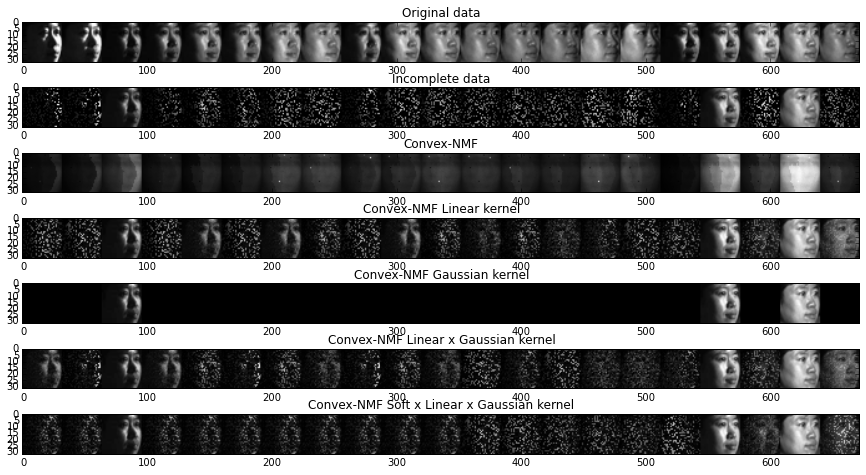

In [95]:
#fig = plt.figure(figsize=(15,12))
f, axarr = plt.subplots(7, 1)
axarr[0].imshow( np.reshape(MF[0:21],(672,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original data')
axarr[1].imshow( np.reshape(MF_ci[0:21],(672,32)).T, cmap='Greys_r' )
axarr[1].set_title('Incomplete data')
axarr[2].imshow( np.reshape(np.dot(cnmf.W, cnmf.H)[0:21],(672,32)).T, cmap='Greys_r' )
axarr[2].set_title('Convex-NMF')
axarr[3].imshow( np.reshape(preimxkl_ci[0:21],(672,32)).T, cmap='Greys_r' )
axarr[3].set_title('Convex-NMF Linear kernel')
axarr[4].imshow( np.reshape(preimxkg_ci[0:21],(672,32)).T, cmap='Greys_r' )
axarr[4].set_title('Convex-NMF Gaussian kernel')
axarr[5].imshow( np.reshape(preimxklxg_ci[0:21],(672,32)).T, cmap='Greys_r' )
axarr[5].set_title('Convex-NMF Linear x Gaussian kernel')
axarr[6].imshow( np.reshape(preimxksxlxg_ci[0:21],(672,32)).T, cmap='Greys_r' )
axarr[6].set_title('Convex-NMF Soft x Linear x Gaussian kernel')
f.set_size_inches(15,8)
#plt.imshow( np.reshape(MF[0:21],(672,32)).T, cmap='Greys_r' )

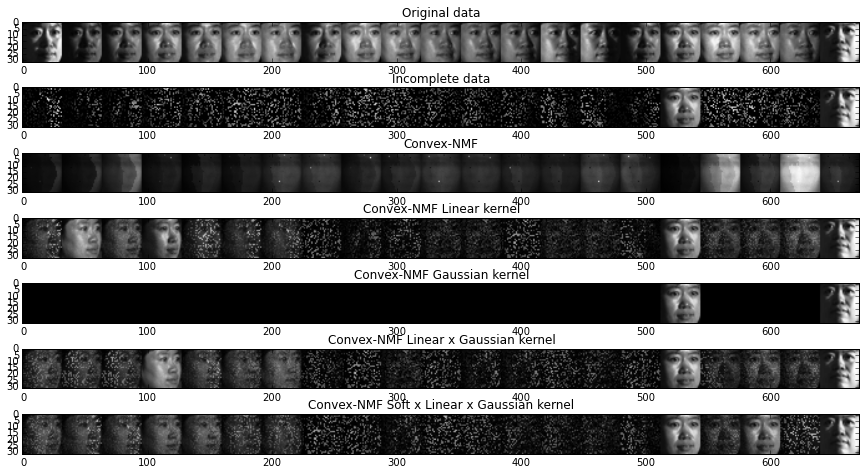

In [96]:
f, axarr = plt.subplots(7, 1)
axarr[0].imshow( np.reshape(MF[22:43],(672,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original data')
axarr[1].imshow( np.reshape(MF_ci[22:43],(672,32)).T, cmap='Greys_r' )
axarr[1].set_title('Incomplete data')
axarr[2].imshow( np.reshape(np.dot(cnmf.W, cnmf.H)[0:21],(672,32)).T, cmap='Greys_r' )
axarr[2].set_title('Convex-NMF')
axarr[3].imshow( np.reshape(preimxkl_ci[22:43],(672,32)).T, cmap='Greys_r' )
axarr[3].set_title('Convex-NMF Linear kernel')
axarr[4].imshow( np.reshape(preimxkg_ci[22:43],(672,32)).T, cmap='Greys_r' )
axarr[4].set_title('Convex-NMF Gaussian kernel')
axarr[5].imshow( np.reshape(preimxklxg_ci[22:43],(672,32)).T, cmap='Greys_r' )
axarr[5].set_title('Convex-NMF Linear x Gaussian kernel')
axarr[6].imshow( np.reshape(preimxksxlxg_ci[22:43],(672,32)).T, cmap='Greys_r' )
axarr[6].set_title('Convex-NMF Soft x Linear x Gaussian kernel')
f.set_size_inches(15,8)

Comparing with STDC (Simultaneous Tensor Decomposition and Completion) approach (Chen, Hsu and Liao, 2014)

The relative square error is computed as 

$$RSE = ||X-\hat{X}||_F/||X||_F$$

In [9]:
#Systematic experiments
import test_kcnmf
test_kcnmf.test(MF)

In [63]:
#Read Input
lines = np.loadtxt("/home/rajaquep/outcomes/cmu_faces_12sep2016.csv", comments="//", delimiter=";", skiprows=1, usecols=(1,2,3,4,5), unpack=False)

In [64]:
missing_rates = [0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98]

rse_lin = lines[np.arange(0,lines.shape[0],3),4]#linear kernel
rse_lin_mean = []
for i in range(len(missing_rates)):
    rse_lin_mean.append( np.min(rse_lin[np.arange(i,rse_lin.shape[0],11)]) )

rse_rbf = lines[np.arange(1,lines.shape[0],3),4]#rbf kernel
rse_rbf_mean = []
for i in range(len(missing_rates)):
    rse_rbf_mean.append( np.min(rse_rbf[np.arange(i,rse_rbf.shape[0],11)]) )

rse_linxrbf = lines[np.arange(2,lines.shape[0],3),4]#linearxrbf kernel
rse_linxrbf_mean = []
for i in range(len(missing_rates)):
    rse_linxrbf_mean.append( np.min(rse_linxrbf[np.arange(i,rse_linxrbf.shape[0],11)]) )

In [7]:
#Systematic experiments - Including Soft kernel
import test_kcnmf
test_kcnmf.test2(MF)

test_kcnmf.py:91: RuntimeWarning: divide by zero encountered in double_scalars
  errorc = np.linalg.norm(MF[idx_inc] - preimxksxlxg_ci[idx_inc])/np.linalg.norm(MF[idx_inc])


In [65]:
#Read Input
lines2 = np.loadtxt("/home/rajaquep/outcomes/cmu_faces_14sep2016.csv", comments="//", delimiter=";", skiprows=1, usecols=(1,2,3,4,5), unpack=False)

In [66]:
missing_rates = [0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98]

rse_softxlinxrbf = lines2[np.arange(0,lines2.shape[0],3),4]#linear kernel
rse_softxlinxrbf_mean = []
for i in range(len(missing_rates)):
    rse_softxlinxrbf_mean.append( np.min(rse_softxlinxrbf[np.arange(i,rse_softxlinxrbf.shape[0],11)]) )

In [76]:
#rse STDC
rse_stdc = [.1282, .1878, .2469, .2652, .3087, .2177, .4852, .6168, .7513, .8587, .9324]

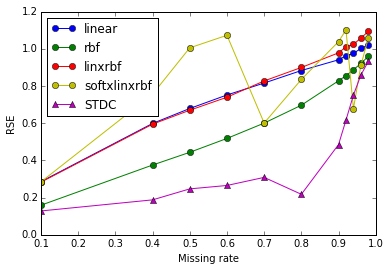

In [78]:
plt.plot(missing_rates,rse_lin_mean,'-ob',label='linear')
plt.plot(missing_rates,rse_rbf_mean,'-og',label='rbf')
plt.plot(missing_rates,rse_linxrbf_mean,'-or',label='linxrbf')
plt.plot(missing_rates,rse_softxlinxrbf_mean,'-oy',label='softxlinxrbf')
plt.plot(missing_rates,rse_stdc,'-^m',label='STDC')
plt.legend(loc=2)
plt.ylabel('RSE')
plt.xlabel('Missing rate')
#plt.title(r'$RSE = ||X-\hat{X}||_F/||X||_F$')

In [31]:
print rse_lin_mean, rse_softxlinxrbf_mean

[0.28971749999999996, 0.60663250000000013, 0.68655559999999993, 0.75735609999999998, 0.82419310000000012, 0.88835429999999993, 0.94981670000000007, 0.97175509999999998, 0.98734790000000017, 1.0101282, 1.0327899999999999] [0.28971749999999996, 0.60663250000000013, 0.68655559999999993, 0.75735609999999998, 0.82419310000000012, 0.88835429999999993, 0.94981670000000007, 0.97175509999999998, 0.98734790000000017, 1.0101282, 1.0327899999999999]


<h3>2.1.6 Computing completion error</h3>
Using incompletion method by STDC authors

In [7]:
#load matlab incomplete tensor.
sio.whosmat('../datasets/cmu_04.mat')

[('X', (30, 11, 21, 623), 'double'),
 ('mark', (30, 11, 21, 623), 'logical'),
 ('Xic', (30, 11, 21, 1024), 'double'),
 ('Xs', (30, 11, 21, 623), 'double'),
 ('idx_ci', (1, 2772), 'double')]

In [8]:
matTF = sio.loadmat('../datasets/cmu_04.mat')#loading tensor of formatted faces' images
TFic = matTF['Xic']
print TFic.shape
MFic = np.reshape(TF,(30*11*21,1024))
print MFic.shape
idx_ci = np.squeeze(matTF['idx_ci'])
print idx_ci.shape

(30, 11, 21, 1024)
(6930, 1024)
(2772,)


In [38]:
mark = matTF['mark']
markm = np.reshape(mark,(30*11*21,623))

In [59]:
Xs = matTF['Xs']
Xsm = np.reshape(mark,(30*11*21,623))

In [32]:
print np.sort(idx_ci)

[   1    2    6 ..., 6923 6929 6930]


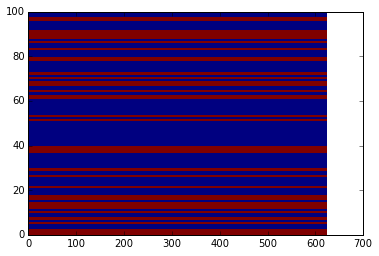

In [43]:
plt.pcolor(markm[:100,:])

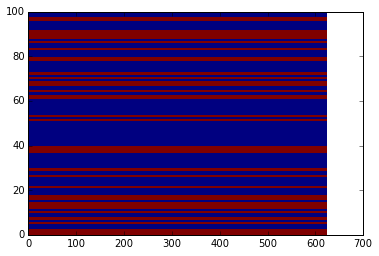

In [61]:
plt.pcolor(Xsm[:100,:])

In [62]:
print sum(markm[100,:]), sum(Xsm[0,:])

0 623


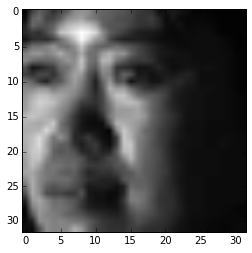

In [58]:
plt.imshow( np.reshape(MFic[95],(32,32)).T, cmap='Greys_r' )

In [9]:
#Systematic experiments
import test_kcnmf
test_kcnmf.test3(MF, MFic, idx_ci, 0.4)

IndexError: index 6930 is out of bounds for axis 1 with size 6930

<h2>2.2 Convex-NMF with Other Tensorial kernel</h2>
<ol>
  <li type="circle">Subjects -> (*Soft kernel)</li>
  <li type="circle">Poses -> Gaussian kernel</li>
  <li type="circle">Illumination changes -> Linear kernel</li>
  <li type="circle">Images -> Linear kernel </li>
</ol>

Computing soft kernel and auxiliar information:

In [9]:
#30x11x21x1024
Ks = kernel.softKernel(MF, 0.3, 1, 30)

In [ ]:
plt.pcolor(Ks[350:,350:])
plt.colorbar()

<h3>2.1.6 Convex-NMF with Soft x Linear x Gaussian</h3>

Exploring sigma with a latent space fixed:

In [17]:
sigmav1 = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1e1, 1e2, 1e3, 1e4, 1e5 ])

In [18]:
rse_cnmf1 = []
for sigmai in sigmav1:
    KsxlxgX_ci = np.dot( kernel._get_kernel(MF_ci, MF_ci,'linxrbf', gamma=(2*sigmai)**-2), Ks)
    cnmf_ksxlxg_ci = CNMF(KsxlxgX_ci, num_bases=10)
    cnmf_ksxlxg_ci.factorize(niter=10)
    rse_cnmf1.append( np.linalg.norm(KsxlxgX_ci - np.dot(cnmf_ksxlxg_ci.W,cnmf_ksxlxg_ci.H))/np.linalg.norm(KsxlxgX_ci) )

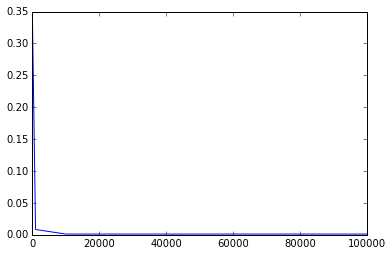

In [19]:
plt.plot(sigmav1, rse_cnmf1)

In [20]:
print rse_cnmf1

[0.32944539369584724, 0.33113212030089734, 0.31906497016570007, 0.32697948684990419, 0.3247530583322964, 0.32045495173275995, 0.31555461657526918, 0.32994966551244775, 0.0083487702282704496, 0.001166157783743215, 0.0011804154246010999]


In [22]:
rse_cnmf2 = []
sigmav2 =  np.linspace(1e4,1e5,20)
for sigmai in sigmav2:
    KsxlxgX_ci = np.dot( kernel._get_kernel(MF_ci, MF_ci,'linxrbf', gamma=(2*sigmai)**-2), Ks)
    cnmf_ksxlxg_ci = CNMF(KsxlxgX_ci, num_bases=10)
    cnmf_ksxlxg_ci.factorize(niter=10)
    rse_cnmf2.append( np.linalg.norm(KsxlxgX_ci - np.dot(cnmf_ksxlxg_ci.W,cnmf_ksxlxg_ci.H))/np.linalg.norm(KsxlxgX_ci) )

min sigma  76315.7894737


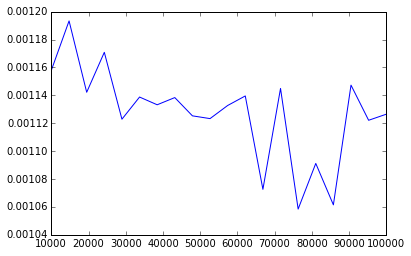

In [23]:
print "min sigma ", sigmav2[np.argmin(rse_cnmf2)]
plt.plot(sigmav2, rse_cnmf2)

Exploring latent space size:

In [16]:
sigma = 76315.7894737
KsxlxgX_ci = np.dot( kernel._get_kernel(MF_ci, MF_ci,'linxrbf', gamma=(2*sigma)**-2), Ks)

In [75]:
bases = np.arange(2,KsxlxgX_ci.shape[1]/32)
fopxsxlxg_ci = np.ones(len(bases))
for idx,item in enumerate(bases):        
    cnmf_ksxlxg_ci = CNMF(KsxlxgX_ci, item)
    cnmf_ksxlxg_ci.factorize(niter=10)
    fopxsxlxg_ci[idx] = np.linalg.norm(KsxlxgX_ci - np.dot(cnmf_ksxlxg_ci.W,cnmf_ksxlxg_ci.H))

1.0


min base  17


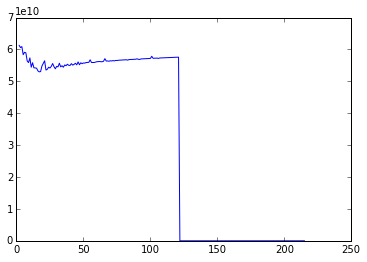

In [30]:
print "min base ", bases[np.argmin(fopxsxlxg_ci[:100])]
plt.plot(bases,fopxsxlxg_ci)

In [17]:
num_bases = 17
cnmf_ksxlxg_ci = CNMF(KsxlxgX_ci, num_bases)
cnmf_ksxlxg_ci.factorize(niter=10)

In [19]:
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 17
preimxksxlxg_ci = np.copy(MF_ci)
for j in idx_inc:
    # \phi(x_i) to linear projection
    xs = MF_ci[max(j-num_bases,0):max(j+num_bases,0)]
    xs = np.resize(xs,(num_bases,num_atts))    
    alpha = cnmf_ksxlxg_ci.H[:,j] #np.mean(cnmf_kg.H,0)
    #print j, xs.shape, alpha.shape
    preimxksxlxg_ci[j], trainErrorskg = kernel.preimage(xs, alpha, 'linxrbf', gamma=(2*sigma)**-2)

In [21]:
print "Error_ori: ", np.linalg.norm(MF - preimxksxlxg_ci)/np.linalg.norm(MF)
print "Error_ci: ", np.linalg.norm(MF_ci - preimxksxlxg_ci)/np.linalg.norm(MF_ci)

Error_ori:  11462.7981095
Error_ci:  0.605892089832


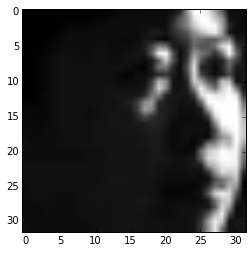

In [35]:
plt.imshow( np.reshape(MF[0],(32,32)).T, cmap='Greys_r' )

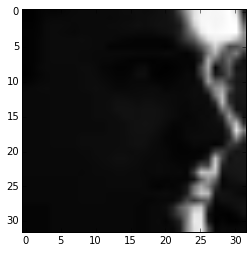

In [42]:
plt.imshow( np.reshape(MF[231],(32,32)).T, cmap='Greys_r' )

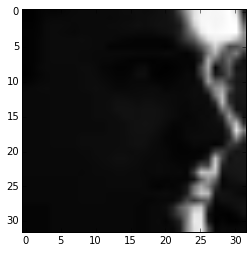

In [41]:
plt.imshow( np.reshape(TF[1,0,0],(32,32)).T, cmap='Greys_r' )

<h2>2.2 Convex-NMF with Loss function computed with only completed objects</h2>

#2. Compute Online Kernel Matrix Factorization

In [ ]:
from sklearn.metrics import pairwise_kernels as K #to compute kernel matrix
from OKMF import OKMF #Online Kernel Matrix Factorization
from kntf import Kntf

2.1 Computing Online kernel-NMF $\phi(X) \approx \phi(X)WH$ (Esteban algorithm adaptation)

Loss function:

$\min_{W,h_i}\frac{1}{2}||\phi(x_i)-\phi(X)Wh_i||^2+\frac{\lambda}{2}||W||_F^2+\frac{\alpha}{2}||h_i||_F^2$

Algorithm iterate assesing the following updated rules (SGD):

$h_t = (W^T_{t-1}K(X,X)W_{t-1}-\alpha I) W^T_{t-1}K(X,x_t)$

$W_t = W_{t-1}-\gamma(k(X,x_t)h_t^T-k(X,X)W_{t-1}h_th_t^T+\lambda W_{t-1})$

In [43]:
#Parameters:
Gamma = 0.01
Lambda = 0.0001
Alpha = 0.3
sigma = 2**-1

In [44]:
#online kernel NMF algorithm (by Esteban)
ok = OKMF(6930,10,100,2,Gamma,Lambda,Alpha,'rbf',gamma=sigma)
#(budgetSize,latentTopics,minibatchSize,epochs,Gamma,Lambda,Alpha,metric,**kwds):

In [45]:
ok.fit(MF,calculateErrors=True)

Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq


Error:

$2\epsilon = tr(K(x_i,x_i))+tr(h^TW^TK(X,x_i))+tr(K(X,x_i)^TWh)+tr(W^TK(X,X)h^TWh)+\lambda tr(W^TW)+\alpha tr(h^Th)$

In [46]:
ok.trainErrors

array([ -1.69227451e+14,   1.49439136e+30,   1.49418218e+30])

2.2 Compute error as $||WH-\phi(X)||_F/||\phi(X)||_F$

In [21]:
error = np.linalg.norm(np.dot(ok.W,ok.H) ,'fro')/np.linalg.norm(ok._KB,'fro')

SyntaxError: invalid syntax (<ipython-input-21-cacf44931215>, line 1)

In [17]:
print error

0.999999999973


2.3 Parameters' selection

In [ ]:
kf = KFold(X.shape[0],n_folds=4,shuffle=True)

In [ ]:
from time import clock

f = open('../outcomes/Results_cmu_faces.csv','w')
f.write('sigma,Budget,Gamma,Lambda,Alpha,tr0,tr1,tr2,ts0,ts1,ts2,time\n')
c = 0.0
budget = 6930
for exp in [-1,0,1]:
        sigma = 2**exp
        for Gamma in [0.01,0.1,0.8]:
            for Lambda in [0.0001, 0.1,0.3]:
                for Alpha in [0.3,0.4,0.6]:
                    suma0 = 0.0
                    suma1 = 0.0
                    suma2 = 0.0
                    suma3 = 0.0
                    suma4 = 0.0
                    suma5 = 0.0
                    time = 0.0
                    c += 1
                    print 'rbf',(c / 224.0)
                    #for train,test in kf:
                    #    ok = OKMF(budget,10,100,2,Gamma,Lambda,Alpha,'rbf',gamma=sigma)
                    #    t0 = clock()
                    #    ok.fit(X,Xt,True)
                    #    ok.fit(X,calculateErrors=True)
                    #    time += clock() - t0
                    #    suma0 += ok.trainErrors[0]
                    #    suma1 += ok.trainErrors[1]
                    #    suma2 += ok.trainErrors[2]
                    #    suma3 += ok.validationErrors[0]
                    #    suma4 += ok.validationErrors[1]
                    #    suma5 += ok.validationErrors[2]
                    ok = OKMF(budget,10,100,5,Gamma,Lambda,Alpha,'rbf',gamma=sigma)
                    t0 = clock()                    
                    ok.fit(MF,calculateErrors=True)
                    time += clock() - t0
                    suma0 += ok.trainErrors[0]
                    suma1 += ok.trainErrors[1]
                    suma2 += ok.trainErrors[2]
                    suma3 += ok.trainErrors[2]
                    suma4 += ok.trainErrors[2]
                    suma5 += ok.trainErrors[2]
                    suma0/=4.0
                    suma1/=4.0
                    suma2/=4.0
                    suma3/=4.0
                    suma4/=4.0
                    suma5/=4.0
                    time/=4.0
                    val = (sigma,budget,Gamma,Lambda,Alpha)
                    val += (suma0,suma1,suma2,suma3,suma4,suma5,time)
                    s = '{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(*val)
                    f.write(s)
f.close()

In [13]:
param_values = np.genfromtxt('../outcomes/Results_cmu_faces.csv', delimiter=',',skip_header=1)

In [21]:
param_values.shape

(81, 12)

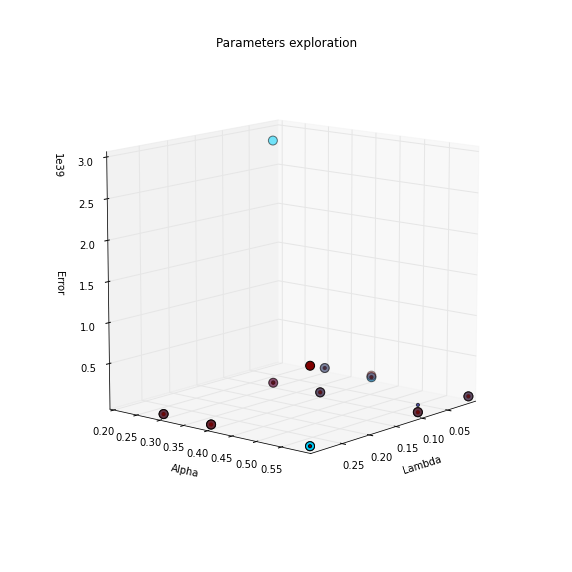

In [42]:
from mpl_toolkits.mplot3d import Axes3D

#fig = plt.scatter(param_values[:,3],param_values[:,4],c=param_values[:,7],s=param_values[:,0])
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

ax.set_title('Parameters exploration')
ax.set_xlabel('Lambda')
ax.set_ylabel('Alpha')
ax.set_zlabel('Error')

ax.set_xlim(0.0001, 0.3)
ax.set_ylim(0.2, 0.6)
ax.set_zlim(2e+29, 3e+39)

ax.view_init(elev=12, azim=40)              # elevation and angle
ax.dist=12                                  # distance

sc = ax.scatter(
           param_values[:,3], param_values[:,4], param_values[:,7],  # data
           c=param_values[:,0],                            # marker colour
           #marker='o',                                # marker shape
           s=(param_values[:,2]*100)                                 # marker size
           )
#plt.colorbar(sc)
plt.show()                                            # render the plot


In [34]:
min(param_values[:,7])

2.12455138591e+29

# Convex Kernel - NMF

In [2]:
from CNMF import CNMF #Source: Esteban Paez
from sklearn import datasets

In [3]:
iris = datasets.load_iris()
iris.data.shape

(150, 4)

In [20]:
splatent = 4
objects = iris.data.shape[0]
#attributes = iris.data.shape[1]
attributes = 150
#X = np.random.rand(objects,attributes)
KX = K(iris.data,iris.data,'linear')
epochs = 2
W0 = np.random.rand(objects,splatent)
G0 = np.random.rand(splatent,attributes)

In [38]:
XP = (abs(KX)+ KX)/2
XN = (abs(KX)- KX)/2
W=W0
G=G0

In [78]:
np.dot(XN,np.dot(W.T,np.dot(G.T,G))).shape

ValueError: shapes (150,150) and (4,150) not aligned: 150 (dim 1) != 4 (dim 0)

In [70]:
n = np.dot(XP,G) + np.dot(XN,np.dot(W,np.dot(G.T,G)))

ValueError: shapes (150,150) and (4,150) not aligned: 150 (dim 1) != 4 (dim 0)

In [79]:
W,G,error = CNMF(iris.data,epochs,W0,G0,calculateErrors = True)

ValueError: shapes (150,4) and (150,4) not aligned: 4 (dim 1) != 150 (dim 0)

In [73]:
#Initialization
splatent = 2
objects = 100
attributes = 3
X = np.random.rand(objects,attributes)
KX = np.dot(X,X.T)
epochs = 2
W0 = np.random.rand(objects,splatent)
G0 = np.random.rand(splatent,attributes)

In [70]:
W,G,error = CNMF(X,epochs,W0,G0,calculateErrors = True)

ValueError: shapes (100,3) and (2,100) not aligned: 3 (dim 1) != 2 (dim 0)

In [76]:
np.dot(X.T,W0)

array([[ 24.58270696,  21.45834436],
       [ 24.18164956,  24.94593442],
       [ 26.30794224,  23.26503157]])